## Setup

In [75]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import cv2
import os
import matplotlib.pyplot as plt

## Prepare the data

In [76]:
# loading all images
images = []
labels = []
root = './dataset/merged/'
for folder in os.listdir(root):
    for image in os.listdir(os.path.join(root, folder)):
        images.append(cv2.imread(os.path.join(root, folder, image)))
        labels.append(folder)

In [77]:
y_normal = pd.DataFrame(labels)
y_normal[0].unique()
y = pd.get_dummies(y_normal)
y.head()

,0_Bengin cases,0_Malignant cases,0_Normal cases
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


the dataset creation cell threw a warning aboout ragged sequences here, so i'm gonna detour here

In [78]:
# verify sizes of all images.
resolution = set()
count = 0
for image in images:
    if image.shape != (512, 512, 3):
        resolution.add(image.shape)
        count += 1
print(str(resolution) + '\n' + f"Number of irregular images: {count}")

{(512, 801, 3), (512, 623, 3), (404, 511, 3), (331, 506, 3)}
Number of irregular images: 61


#FIXTHIS 61 images have irregular resolutions. Removing them for now

In [79]:
filtimg = list()

for idx in range(len(images)):
    if images[idx].shape == (512, 512, 3):
        filtimg.append(images[idx])
    else:
        y.drop(idx, axis='rows', inplace=True)

if (len(images) - len(filtimg)) == 61:
    images = filtimg

In [80]:
dataset = np.array(images)

dataset.shape[0] == y.shape[0]

True

In [81]:
y.shape

(1036, 3)

In [96]:
num_classes = 3
input_shape = (180, 180, 3)

x_train, x_test, y_train, y_test = train_test_split(dataset, y, test_size = 0.25,
                                                    shuffle=True)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (777, 512, 512, 3) - y_train shape: (777, 3)
x_test shape: (259, 512, 512, 3) - y_test shape: (259, 3)


# Hyperparameter initialisation and Dataset finalization

In [83]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 14
num_epochs = 15
image_size = 180  # We'll resize input images to this size
patch_size = 18  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [84]:
# convert dataset into tensorflow `Dataset` objects
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = batch_size
IMG_SIZE = 180

def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label

train_ds = tf.keras.utils.image_dataset_from_directory(
  root,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size)

train_ds_simple = tf.data.Dataset.from_tensor_slices((x_train, y_train))

test_ds = tf.keras.utils.image_dataset_from_directory(
  root,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size)

train_ds_simple = (
    train_ds_simple.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    test_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

Found 1097 files belonging to 3 classes.
Using 878 files for training.
Found 1097 files belonging to 3 classes.
Using 219 files for validation.


## Use data augmentation

In [85]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


In [86]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(14, 180, 180, 3)
(14,)


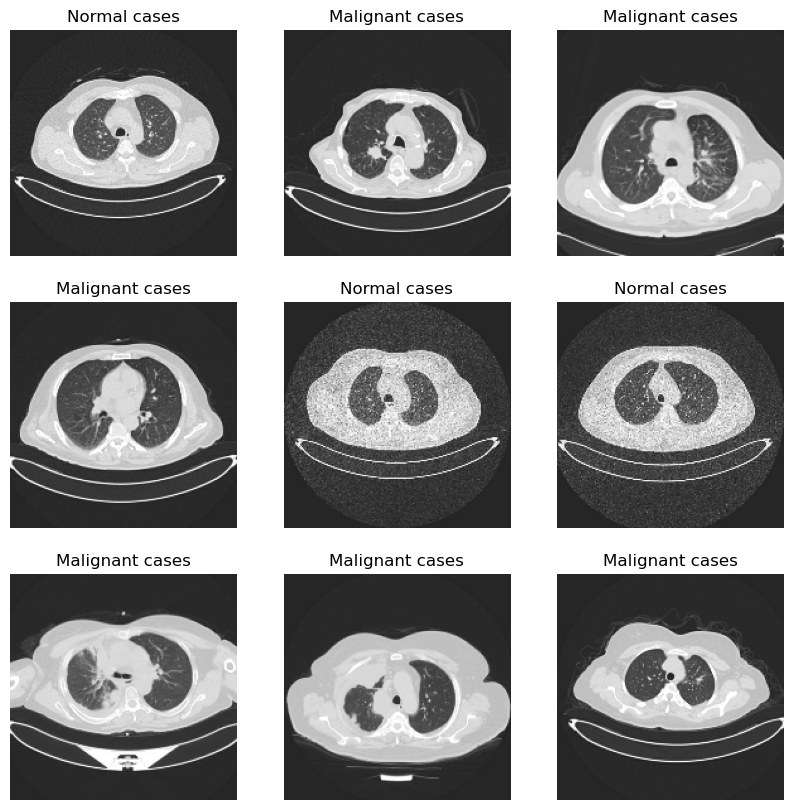

In [87]:
#visualise the data
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(train_ds.class_names[label])
  plt.axis("off")

## Implement multilayer perceptron (MLP)

In [88]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [89]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


In [90]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


Image size: 180 X 180
Patch size: 18 X 18
Patches per image: 100
Elements per patch: 972


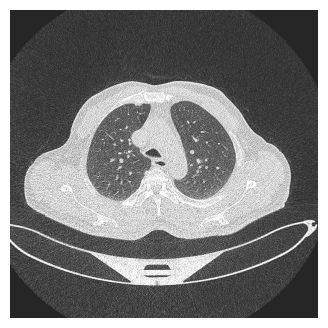

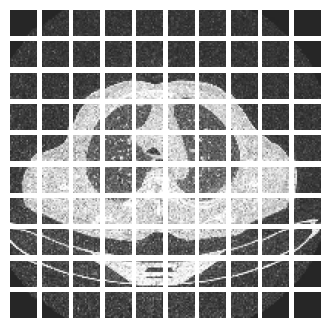

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [102]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [103]:
model = create_vit_classifier()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 180, 180, 3)          7         ['input_10[0][0]']            
 ial)                                                                                             
                                                                                                  
 patches_3 (Patches)         (None, None, 972)            0         ['data_augmentation[2][0]']   
                                                                                                  
 patch_encoder_3 (PatchEnco  (None, 100, 64)              68672     ['patches_3[0][0]']     

In [104]:
# training and validation
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds, epochs=25)

test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/25


/home/andyd/miniconda3/envs/nlp/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)
2023-08-03 16:06:12.669140: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5606e527a0f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-03 16:06:12.669196: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 Super, Compute Capability 7.5
2023-08-03 16:06:12.713528: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-03 16:06:13.003534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] L

63/63 [==============================] - 29s 88ms/step - loss: 1.5261e-07 - accuracy: 0.3337
Epoch 2/25
63/63 [==============================] - 6s 89ms/step - loss: 1.5261e-07 - accuracy: 0.3588
Epoch 3/25
63/63 [==============================] - 6s 92ms/step - loss: 1.5261e-07 - accuracy: 0.3326
Epoch 4/25
63/63 [==============================] - 6s 87ms/step - loss: 1.5261e-07 - accuracy: 0.3428
Epoch 5/25
63/63 [==============================] - 6s 86ms/step - loss: 1.5261e-07 - accuracy: 0.3212
Epoch 6/25
63/63 [==============================] - 6s 91ms/step - loss: 1.5261e-07 - accuracy: 0.3383
Epoch 7/25
63/63 [==============================] - 6s 91ms/step - loss: 1.5261e-07 - accuracy: 0.3588
Epoch 8/25
63/63 [==============================] - 7s 104ms/step - loss: 1.5261e-07 - accuracy: 0.3428
Epoch 9/25
63/63 [==============================] - 6s 87ms/step - loss: 1.5261e-07 - accuracy: 0.3166
Epoch 10/25
63/63 [==============================] - 6s 87ms/step - loss: 1.5261e-

ValueError: in user code:

    File "/home/andyd/miniconda3/envs/nlp/lib/python3.10/site-packages/keras/src/engine/training.py", line 1972, in test_function  *
        return step_function(self, iterator)
    File "/home/andyd/miniconda3/envs/nlp/lib/python3.10/site-packages/keras/src/engine/training.py", line 1956, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/andyd/miniconda3/envs/nlp/lib/python3.10/site-packages/keras/src/engine/training.py", line 1944, in run_step  **
        outputs = model.test_step(data)
    File "/home/andyd/miniconda3/envs/nlp/lib/python3.10/site-packages/keras/src/engine/training.py", line 1850, in test_step
        y_pred = self(x, training=False)
    File "/home/andyd/miniconda3/envs/nlp/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/andyd/miniconda3/envs/nlp/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_4" is incompatible with the layer: expected shape=(None, 180, 180, 3), found shape=(None, None, 180, 180, 3)


In [ ]:
def get_training_model():
    model = tf.keras.Sequential(
        [
            layers.Conv2D(16, (5, 5), activation="relu", input_shape=(512, 512, 3)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.GlobalAvgPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(y.shape[1], activation="softmax"),
        ]
    )
    return model

In [ ]:
model = get_training_model()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"], run_eagerly=True)
model.fit(train_ds, epochs=10)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))
model.summary()

Epoch 1/10
56/56 [==============================] - 7s 105ms/step - loss: 0.3616 - accuracy: 0.0476
Epoch 2/10
56/56 [==============================] - 6s 100ms/step - loss: 0.1076 - accuracy: 0.0129
Epoch 3/10
56/56 [==============================] - 6s 96ms/step - loss: 0.0391 - accuracy: 0.0245
Epoch 4/10
56/56 [==============================] - 6s 97ms/step - loss: 0.0502 - accuracy: 0.0142
Epoch 5/10
56/56 [==============================] - 6s 97ms/step - loss: 0.0427 - accuracy: 0.0180
Epoch 6/10
56/56 [==============================] - 6s 96ms/step - loss: 0.0535 - accuracy: 0.0708
Epoch 7/10
56/56 [==============================] - 6s 100ms/step - loss: 0.0378 - accuracy: 0.3436
Epoch 8/10
56/56 [==============================] - 6s 99ms/step - loss: 0.0238 - accuracy: 0.3089
Epoch 9/10
56/56 [==============================] - 6s 102ms/step - loss: 0.0491 - accuracy: 0.3359
Epoch 10/10
19/19 [==============================] - 1s 32ms/step - loss: 1.0523 - accuracy: 0.3938
Test 